# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/).


In [0]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


# Vanilla Autoencoder

## Data preparation


In [0]:
import numpy as np
import os
from imageio import imread
from PIL import Image
import pandas as pd

#np.array(Image.fromarray(img).resize([dimx,dimy]))

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [0]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [0]:
attrs_tensor = torch.tensor(attrs.values.astype(np.float32))
attrs_tensor.shape

torch.Size([13143, 73])

In [0]:
X_train, X_val, y_train, y_val = train_test_split(data, attrs_tensor, test_size=0.2, shuffle=False)

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [0]:
def plot_gallery(images, n_row=3, n_col=6, need_denorm=False):
    """Helper function to plot a gallery of portraits"""
    if torch.is_tensor(images):
      images = images.numpy()
      if need_denorm:
          mean_correction = np.asarray([0.628, 0.471, 0.384]).reshape(3, 1, 1)
          std_correction = np.asarray([0.205, 0.182, 0.178]).reshape(3, 1, 1)
          images = np.multiply(images, std_correction) + mean_correction
      images = images.transpose((0, 2, 3, 1))
      images = np.clip(images, 0, 1)

    h = images.shape[1]
    w = images.shape[2]
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass
    plt.show()

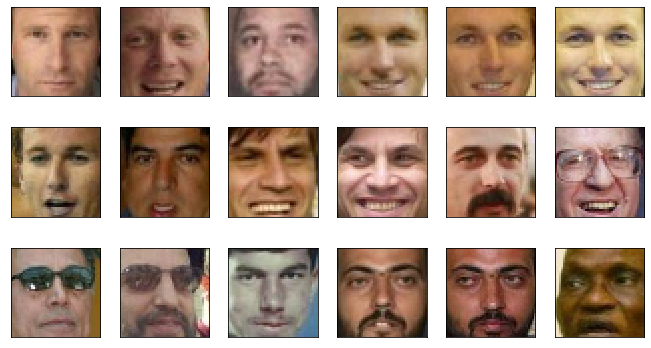

In [0]:
plot_gallery(X_train)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [0]:
class MyDataset(Dataset):
    def __init__(self, files, props):
        super().__init__()
        self.files = files
        self.props = props
        self.len_ = len(self.files)
    
    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        transform = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor(),
          #transforms.Normalize([0.628, 0.471, 0.384], [0.205, 0.182, 0.178])
        ])

        x = self.files[index]
        x = Image.fromarray(x)
        x = transform(x)
        y = self.props[index]
        return x, y

In [0]:
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
all_dataset = MyDataset(data, attrs_tensor)

## AE architecture

<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Реализуем autoencoder:

In [0]:
#from copy import deepcopy

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), input.size(1), 1, 1)

class Autoencoder(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
  
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, z_dim, kernel_size=3),
            nn.BatchNorm2d(z_dim),
            Flatten()   )
        
        self.decoder = nn.Sequential(
            UnFlatten(),             
            nn.ConvTranspose2d(z_dim, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 3, kernel_size=3, padding=1)  )

    def decode(self, x):
        return self.decoder(x)
    
    def encode(self, latent_code):
        return self.encoder(latent_code)

    def forward(self, x):
        x = self.encode(x)
        latent_code = x
        reconstruction = self.decode(x)
        return reconstruction, latent_code

In [0]:
z_dim = 1024 
model = Autoencoder(z_dim=z_dim).to(DEVICE)

In [0]:
def train(train_dataset, val_dataset, model, epochs, batch_size, lr=1e-3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    log_template = "Finished epoch {ep:03d} | train_loss {t_loss:0.4f} | val_loss {v_loss:0.4f}"


    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        train_loss = fit_epoch(model, train_loader, criterion, optimizer)
        val_loss = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, val_loss))
        print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # перевод модели в режим train - в данном конкретном случае ни на что не влияет,
    # но необходимо, если в модели есть слои BatchNorm или DropOut
    model.train()
    running_loss = 0.0
    processed_data = 0
    
    for inputs, prop in train_loader:
        inputs = inputs.to(DEVICE)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
           
    train_loss = running_loss / processed_data
    return train_loss

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, prop in val_loader:
        inputs = inputs.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    return val_loss

In [0]:
history=[]
history =  train(train_dataset, val_dataset, model=model, epochs=5, batch_size=64, lr=2e-3)
history += train(train_dataset, val_dataset, model=model, epochs=12, batch_size=64, lr=1e-3)
history += train(train_dataset, val_dataset, model=model, epochs=5, batch_size=64, lr=0.3e-3)
history += train(train_dataset, val_dataset, model=model, epochs=3, batch_size=64, lr=0.1e-3)
history += train(train_dataset, val_dataset, model=model, epochs=3, batch_size=64, lr=0.03e-3)
history += train(train_dataset, val_dataset, model=model, epochs=3, batch_size=64, lr=0.01e-3)

Finished epoch 001 | train_loss 0.0727 | val_loss 0.0113
Finished epoch 002 | train_loss 0.0093 | val_loss 0.0077
Finished epoch 003 | train_loss 0.0071 | val_loss 0.0075
Finished epoch 004 | train_loss 0.0055 | val_loss 0.0050
Finished epoch 005 | train_loss 0.0048 | val_loss 0.0044
Finished epoch 001 | train_loss 0.0047 | val_loss 0.0044
Finished epoch 002 | train_loss 0.0042 | val_loss 0.0039
Finished epoch 003 | train_loss 0.0040 | val_loss 0.0044
Finished epoch 004 | train_loss 0.0038 | val_loss 0.0038
Finished epoch 005 | train_loss 0.0037 | val_loss 0.0032
Finished epoch 006 | train_loss 0.0033 | val_loss 0.0029
Finished epoch 007 | train_loss 0.0034 | val_loss 0.0032
Finished epoch 008 | train_loss 0.0032 | val_loss 0.0029
Finished epoch 009 | train_loss 0.0030 | val_loss 0.0027
Finished epoch 010 | train_loss 0.0030 | val_loss 0.0024
Finished epoch 011 | train_loss 0.0029 | val_loss 0.0024
Finished epoch 012 | train_loss 0.0029 | val_loss 0.0026
Finished epoch 001 | train_loss

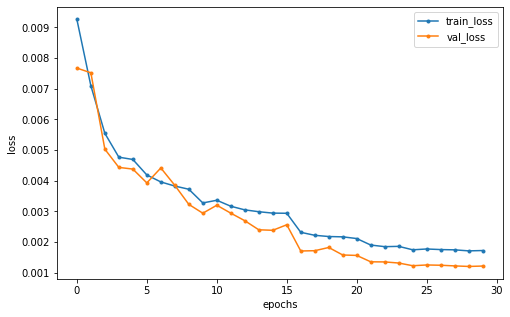

In [0]:
train_loss, val_loss = zip(*history)

plt.figure(figsize=(8, 5))
plt.plot(train_loss[1:], label="train_loss", marker='.')
plt.plot(val_loss[1:], label="val_loss", marker='.')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Посмотрим, как автоэнкодер кодирует и восстанавливает картинки:

Оригинальные


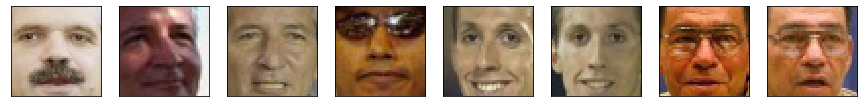

Восстановленные


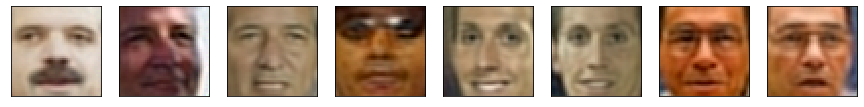

In [0]:
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
inputs, prop = next(iter(val_loader))

model.eval()
outputs, latent = model(inputs.to(DEVICE))
outputs = outputs.data.cpu()

print('Оригинальные')
plot_gallery(inputs, n_row=1, n_col=8, need_denorm=False)
print('Восстановленные')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

Not bad, right? 

## Sampling

Теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ.

Возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:


In [0]:
mean = torch.zeros((z_dim,))
std = torch.zeros((z_dim,))
n_pics = 0
all_loader = DataLoader(all_dataset, batch_size=8, shuffle=False)

model.eval()
for inputs, prop in all_loader:
    latent = model.encode(inputs.to(DEVICE))
    n_pics += inputs.shape[0]
    mean += latent.data.mean(axis=0).cpu() * inputs.shape[0]
    std += latent.data.std(axis=0).cpu() * inputs.shape[0]

mean = mean / n_pics
std = std / n_pics
new_latent = np.random.normal(loc=mean, scale = 0.4*std, size=(8,z_dim))
new_latent.shape

(8, 1024)

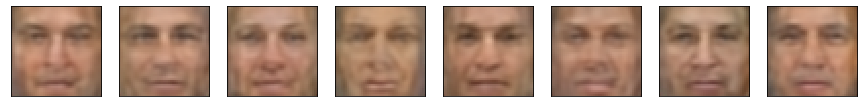

In [0]:
# Сгенерированные новые изображения
model.eval()
outputs = model.decode(torch.Tensor(new_latent).to(DEVICE))
outputs = outputs.data.cpu()
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

## Smile adding

Попробуем пририсовывать людям улыбки =)

In [0]:
# Создадим 2 новых датасета из грустных и счастливых
lim = 1
happy_dataset = MyDataset(data[attrs['Smiling']>lim], attrs_tensor[attrs['Smiling']>lim])
sad_dataset = MyDataset(data[attrs['Smiling']<-lim], attrs_tensor[attrs['Smiling']<-lim])

happy_loader = DataLoader(happy_dataset, batch_size=8, shuffle=False)
sad_loader = DataLoader(sad_dataset, batch_size=8, shuffle=False)

print('счастливых ', len(data[attrs['Smiling']>lim]))
print('грустных ', len(data[attrs['Smiling']<-lim]))

счастливых  2654
грустных  3598


In [0]:
# Посчитаем средний латентный слой счастливых
happy_mean = torch.zeros((z_dim,))
n_pics = 0

model.eval()
for inputs, prop in happy_loader:
    latent = model.encode(inputs.to(DEVICE))
    n_pics += inputs.shape[0]
    happy_mean += latent.data.mean(axis=0).cpu() * inputs.shape[0]
happy_mean = happy_mean / n_pics

In [0]:
# Посчитаем средний латентный слой грустных
sad_mean = torch.zeros((z_dim,))
n_pics = 0

model.eval()
for inputs, prop in sad_loader:
    latent = model.encode(inputs.to(DEVICE))
    n_pics += inputs.shape[0]
    sad_mean += latent.data.mean(axis=0).cpu() * inputs.shape[0]
sad_mean = sad_mean / n_pics

In [0]:
# Найдем разницу между грустными и счастливыми
delta_mean = happy_mean - sad_mean

Грустные


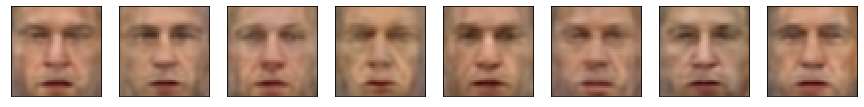

Средние


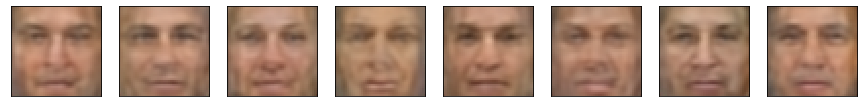

Счастливые


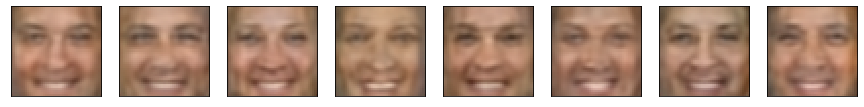

In [0]:
# Сгенерируем новые изображения грустных и счастливых
model.eval()
outputs = model.decode((torch.Tensor(new_latent)-delta_mean).to(DEVICE))
outputs = outputs.data.cpu()
print('Грустные')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

outputs = model.decode((torch.Tensor(new_latent)-0).to(DEVICE))
outputs = outputs.data.cpu()
print('Средние')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

outputs = model.decode((torch.Tensor(new_latent)+delta_mean).to(DEVICE))
outputs = outputs.data.cpu()
print('Счастливые')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

Грустные


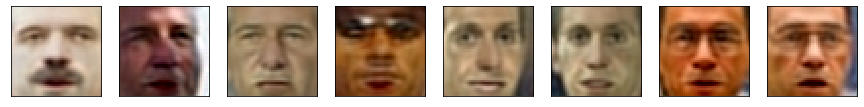

Оригинальные


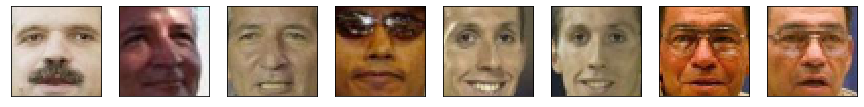

Счастливые


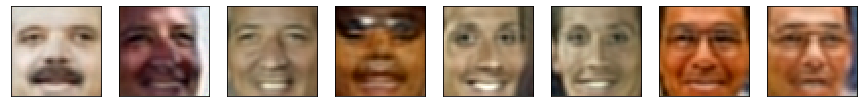

In [0]:
# Возьмем библиотечные изображения, сделаем их грустными и счастливыми
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
inputs, prop = next(iter(val_loader))

# Сначала получим латентный слой
model.eval()
latent = model.encode(inputs.to(DEVICE))
latent = latent.data.cpu()

# Прогоним латентный слой через декодер
outputs = model.decode((latent-delta_mean).to(DEVICE)) 
outputs = outputs.data.cpu()
print('Грустные')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False) # грустные

print('Оригинальные')
plot_gallery(inputs, n_row=1, n_col=8, need_denorm=False) # оригинальные

outputs = model.decode((latent+delta_mean).to(DEVICE))
outputs = outputs.data.cpu()
print('Счастливые')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False) # счастливые

Сделаем плавный переход от фотографии к фотографии:

In [0]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
inputs, prop = next(iter(val_loader))

model.eval()
latent = model.encode(inputs.to(DEVICE))
latent = latent.data.cpu()

# получим непрерывный линейно интерполированный вектор плавного перехода от одной фотографии к другой
n_steps = 20
contin_latent = latent[0:1] # первая картинка

for i in range(latent.shape[0]-1):
  d_latent = (latent[i+1:i+2] - latent[i:i+1]) / n_steps
  for i in range(n_steps):
    contin_latent = torch.cat( (contin_latent, contin_latent[-1] + d_latent), 0 )
print(contin_latent.shape)

torch.Size([301, 1024])


In [0]:
# Прогоним латентный слой через декодер
model.eval()
outputs = model.decode((contin_latent).to(DEVICE)) 
outputs = outputs.data.cpu()

In [0]:
from matplotlib import animation, rc

def outputs_to_numpy(images):
      images = images.numpy()
      images = images.transpose((0, 2, 3, 1))
      images = np.clip(images, 0, 1)
      return images

fig = plt.figure()
images = outputs_to_numpy(outputs)

ims = []
for i in range(len(images)):
    im = plt.imshow(images[i], cmap=plt.cm.gray, animated=True, interpolation='nearest')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')
rc('animation', html='jshtml')
ani

Output hidden; open in https://colab.research.google.com to view.

# Conditional Autoencoder




## Data preparation

Будем использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/)

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()]   )

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## CAE architecture



![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



In [0]:
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + 10, 256),
            #nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            #nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 4),
            #nn.BatchNorm1d(22)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(4+10, 64),
            #nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            #nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28)  )

    def encode(self, x):
        OHE = x[:,-10:]
        latent_code = self.encoder(x)
        latent_code = torch.cat([latent_code,OHE], 1)
        return latent_code

    def decode(self, latent_code):
        x = self.decoder(latent_code)
        return x.view((-1,1,28,28))
    
    def forward(self, x):
        x = self.encode(x)
        latent_code = x
        x = self.decode(latent_code)
        return x, latent_code

In [0]:
MNISTmodel = MNISTAutoencoder().to(DEVICE)
MNISTmodel

MNISTAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [0]:
import torchsummary
torchsummary.summary( MNISTmodel, (28*28+10,) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         203,520
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 22]           1,430
            Linear-8                   [-1, 64]           2,112
              ReLU-9                   [-1, 64]               0
           Linear-10                  [-1, 128]           8,320
             ReLU-11                  [-1, 128]               0
           Linear-12                  [-1, 256]          33,024
             ReLU-13                  [-1, 256]               0
           Linear-14                  [

In [0]:
def merge_input(inputs, labels):
  OHE = torch.zeros((inputs.shape[0], 10))
  for i in range(len(labels)):
    OHE[i, labels[i]] = 1 # labels обязательно должны быть int
  inputs = inputs.view((-1, 28*28))
  merged_inputs = torch.cat([inputs, OHE], 1)
  return merged_inputs

In [0]:
def train_MNIST(train_dataset, val_dataset, model, epochs, batch_size, lr=1e-3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "Finished epoch {ep:03d} | train_loss {t_loss:0.4f} | val_loss {v_loss:0.4f}"

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        train_loss = fit_epoch_MNIST(model, train_loader, criterion, optimizer)
        val_loss = eval_epoch_MNIST(model, val_loader, criterion)
        history.append((train_loss, val_loss))
        print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [0]:
def fit_epoch_MNIST(model, train_loader, criterion, optimizer):
    # перевод модели в режим train - в данном конкретном случае ни на что не влияет,
    # но необходимо, если в модели есть слои BatchNorm или DropOut
    model.train()
    running_loss = 0.0
    processed_data = 0
    
    for inputs, labels in train_loader:
        merged_inputs = merge_input(inputs, labels).to(DEVICE)
        inputs = inputs.to(DEVICE) # размерность input [-1,1,28,28]
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs, latent = model(merged_inputs) # размерность output [-1,1,28,28]
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
           
    train_loss = running_loss / processed_data
    return train_loss

In [0]:
def eval_epoch_MNIST(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, labels in val_loader:
        merged_inputs = merge_input(inputs, labels).to(DEVICE)
        inputs = inputs.to(DEVICE) # размерность input [-1,1,28,28]

        with torch.set_grad_enabled(False):
            outputs, latent = model(merged_inputs) # размерность output [-1,1,28,28]
            loss = criterion(outputs, inputs)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    return val_loss

In [0]:
history=[]
history =  train_MNIST(trainset, testset, model=MNISTmodel, epochs=2, batch_size=64, lr=2e-3)
history += train_MNIST(trainset, testset, model=MNISTmodel, epochs=5, batch_size=64, lr=1e-3)
history += train_MNIST(trainset, testset, model=MNISTmodel, epochs=2, batch_size=64, lr=0.3e-3)
history += train_MNIST(trainset, testset, model=MNISTmodel, epochs=2, batch_size=64, lr=0.1e-3)
history += train_MNIST(trainset, testset, model=MNISTmodel, epochs=2, batch_size=64, lr=0.03e-3)
history += train_MNIST(trainset, testset, model=MNISTmodel, epochs=2, batch_size=64, lr=0.01e-3)

Finished epoch 001 | train_loss 0.0382 | val_loss 0.0308
Finished epoch 002 | train_loss 0.0299 | val_loss 0.0289
Finished epoch 001 | train_loss 0.0280 | val_loss 0.0274
Finished epoch 002 | train_loss 0.0274 | val_loss 0.0270
Finished epoch 003 | train_loss 0.0270 | val_loss 0.0267
Finished epoch 004 | train_loss 0.0267 | val_loss 0.0264
Finished epoch 005 | train_loss 0.0265 | val_loss 0.0264
Finished epoch 001 | train_loss 0.0256 | val_loss 0.0256
Finished epoch 002 | train_loss 0.0255 | val_loss 0.0255
Finished epoch 001 | train_loss 0.0252 | val_loss 0.0252
Finished epoch 002 | train_loss 0.0251 | val_loss 0.0252
Finished epoch 001 | train_loss 0.0250 | val_loss 0.0251
Finished epoch 002 | train_loss 0.0250 | val_loss 0.0251
Finished epoch 001 | train_loss 0.0249 | val_loss 0.0251
Finished epoch 002 | train_loss 0.0249 | val_loss 0.0251


In [0]:
def plot_MNIST(images, n_col=6, n_row=1):
    images = images.squeeze().numpy()
    images = np.clip(images, 0, 1)

    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
    plt.show()

Оригинальные


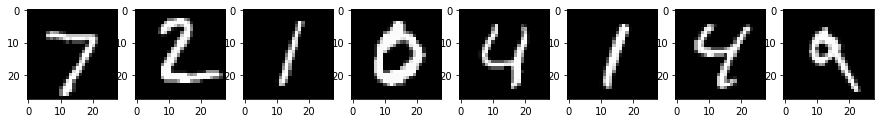

Реконструированные


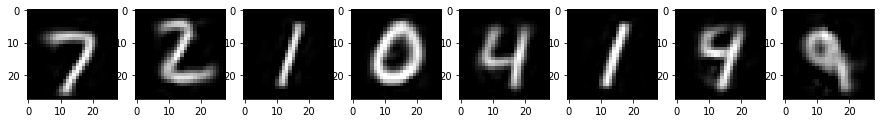

In [0]:
MNISTmodel.eval()

val_loader = DataLoader(testset, batch_size=8, shuffle=False)
inputs, labels = next(iter(val_loader))
merged_inputs = merge_input(inputs, labels).to(DEVICE)

outputs, latent = MNISTmodel(merged_inputs)
outputs = outputs.data.cpu()

print('Оригинальные')
plot_MNIST(inputs, n_col=8)
print('Реконструированные')
plot_MNIST(outputs, n_col=8)

## Sampling

In [0]:
# вычислим среднее и дисперсию латентного слоя
mean = torch.zeros((4+10))
std = torch.zeros((4+10))
n_pics = 0
train_loader = DataLoader(trainset, batch_size=64, shuffle=False)

MNISTmodel.eval()
for inputs, labels in train_loader:
    merged_inputs = merge_input(inputs, labels).to(DEVICE)
    outputs, latent = MNISTmodel(merged_inputs)
    n_pics += inputs.shape[0]
    mean += latent.data.mean(axis=0).cpu() * inputs.shape[0]
    std += latent.data.std(axis=0).cpu() * inputs.shape[0]
mean = mean / n_pics
std = std / n_pics

print('mean = ', mean[:4], mean[4:])
print('std = ', std[:4], std[4:])

mean =  tensor([1.7754, 0.1296, 1.6893, 1.6975]) tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])
std =  tensor([1.5309, 2.6012, 2.2189, 2.0795]) tensor([0.2940, 0.3138, 0.2950, 0.3001, 0.2925, 0.2832, 0.2955, 0.3031, 0.2931,
        0.2955])


Сгенерируем числа от 0 до 9:

In [0]:
# 10 векторов для каждого числа от 0 до 9
new_latent = np.random.normal(loc=mean, scale = 0.01*std, size=(10, 4+10) )
new_latent[:,-10:] = 0.0
for i in range(new_latent.shape[0]):
  new_latent[i,-10+i] = 1.0
new_latent = torch.Tensor(new_latent)

Цифры от 0 до 9


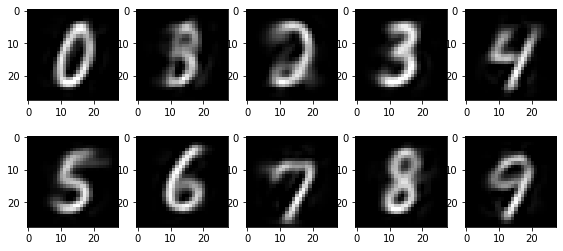

In [0]:
MNISTmodel.eval()

outputs = MNISTmodel.decode(new_latent.to(DEVICE))
outputs = outputs.data.cpu()
print('Цифры от 0 до 9')
plot_MNIST(outputs, n_row=2, n_col=5)

## 2d projection

Спроецируем латентные векторы в двумерное пространство:

In [0]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
all_labels = torch.LongTensor(())
all_latent = torch.Tensor(())

MNISTmodel.eval()
for inputs, labels in train_loader:
    all_labels = torch.cat((all_labels, labels.cpu()))
    merged_inputs = merge_input(inputs, labels).to(DEVICE)
    latent = MNISTmodel.encode(merged_inputs)
    latent = latent.data.cpu()
    all_latent = torch.cat((all_latent, latent))
all_labels = all_labels.numpy()
all_latent = all_latent.cpu().numpy()
all_latent.shape

(60000, 14)

In [0]:
kolvo = 2000
all_labels = all_labels[:kolvo]
all_latent = all_latent[:kolvo]

TSNE:

In [0]:
from sklearn.manifold import TSNE
all_latent_2d_TSNE = TSNE(n_components=2).fit_transform(all_latent)
all_latent_2d_TSNE_cut = TSNE(n_components=2).fit_transform(all_latent[:,:6])
all_latent_2d_TSNE.shape

(2000, 2)

для TSNE полученного из полного латентного вектора


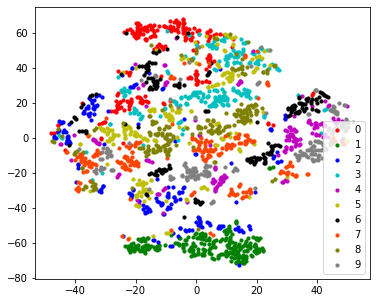

для TSNE полученного из обрезанного латентного вектора без OneHotEncoding


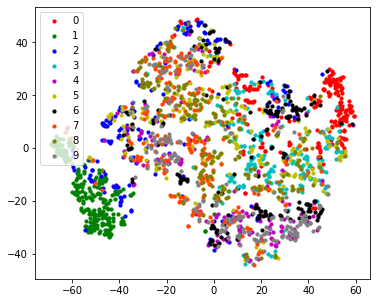

In [0]:
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orangered', 'olive', 'gray'

print('для TSNE полученного из полного латентного вектора')
plt.figure(figsize=(6, 5))
for i, color in zip(range(10), colors):
    plt.scatter(all_latent_2d_TSNE[all_labels == i, 0], all_latent_2d_TSNE[all_labels == i, 1], s=10, c=color, label=str(i))
plt.legend()
plt.show()

print('для TSNE полученного из обрезанного латентного вектора без OneHotEncoding')
plt.figure(figsize=(6, 5))
for i, color in zip(range(10), colors):
    plt.scatter(all_latent_2d_TSNE_cut[all_labels == i, 0], all_latent_2d_TSNE_cut[all_labels == i, 1], s=10, c=color, label=str(i))
plt.legend()
plt.show()

PCA:

In [0]:
from sklearn.decomposition import PCA
all_latent_2d_PCA = PCA(n_components=2).fit(all_latent).transform(all_latent)
all_latent_2d_PCA_cut = PCA(n_components=2).fit(all_latent[:,:6]).transform(all_latent[:,:6])
all_latent_2d_PCA.shape

(2000, 2)

для PCA полученного из полного латентного вектора


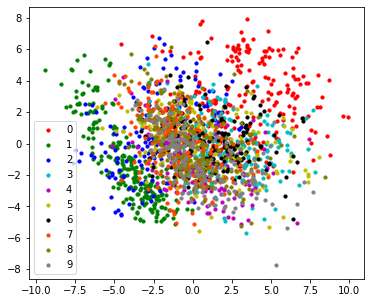

для PCA полученного из обрезанного латентного вектора без OneHotEncoding


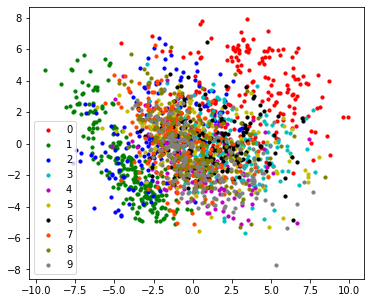

In [0]:
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orangered', 'olive', 'gray'

print('для PCA полученного из полного латентного вектора')
plt.figure(figsize=(6, 5))
for i, color in zip(range(10), colors):
    plt.scatter(all_latent_2d_PCA[all_labels == i, 0], all_latent_2d_PCA[all_labels == i, 1], s=10, c=color, label=str(i))
plt.legend()
plt.show()

print('для PCA полученного из обрезанного латентного вектора без OneHotEncoding')
plt.figure(figsize=(6, 5))
for i, color in zip(range(10), colors):
    plt.scatter(all_latent_2d_PCA_cut[all_labels == i, 0], all_latent_2d_PCA_cut[all_labels == i, 1], s=10, c=color, label=str(i))
plt.legend()
plt.show()

Выводы:

1. Можно заметить, что векторы кластеризированны, что удобно для модели при дублировании картинки, но не полезно при генерации новых изображений.
2. По TSNE также можно увидеть, что данные не непрерывны, а обособлены друг от друга, что может привести к некорректной работе декодера при генерации новой картинки из случайного вектора, попавшего в область, на которой генератор не обучен.

# Variational Autoencoder

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), input.size(1), 1, 1)

class VAE(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            #nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
  
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            #nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            #nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            #nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            #nn.ReLU(),
            Flatten()
            )

        self.fc1 = nn.Linear(256, z_dim)
        self.fc2 = nn.Linear(256, z_dim)
        self.fc3 = nn.Linear(z_dim, 256)
        self.relu = nn.ReLU()

        self.decoder = nn.Sequential(
            UnFlatten(),             
            nn.ConvTranspose2d(256, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            #nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            #nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            #nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 3, kernel_size=3, padding=1),
            nn.Sigmoid()       # Сигмоида для BCE, иначе ломается   
            )
        
    def encode(self, x):
        x = self.encoder(x)
        x = self.relu(x)
        mu, logsigma = self.fc1(x), self.fc2(x)
        return mu, logsigma

    def reparameterize(self, mu, logsigma):     
        if self.training:
            std = logsigma.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())*1
            return mu + std * eps
        else:
            return mu
  
    def decode(self, z):
        z = self.fc3(z)
        z = self.relu(z)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma


In [0]:
z_dim=512
VAEmodel = VAE(z_dim=z_dim).to(DEVICE)
#VAEmodel

In [0]:
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
#all_dataset = MyDataset(data, attrs_tensor)

Определим лосс и его компоненты для VAE:

In [0]:
def KL_divergence(mu, logsigma):
    # часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    # KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #return -0.5 * (1 + 2*logsigma - mu**2 - torch.exp(logsigma)**2).sum() # это для std = logsigma.exp_()
    return -0.5 * (1 + logsigma - mu.pow(2) - logsigma.exp()).sum() / mu.shape[0] # это для std = (0.5*logsigma).exp_()

def log_likelihood(x, reconstruction):
    # часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    loss = nn.BCELoss(reduction='sum') # нужна сигмоида в конце энкодера
    #return F.binary_cross_entropy(reconstruction, x)
    #loss = nn.MSELoss()
    return loss(reconstruction, x) / x.shape[0]

def loss_vae(x, mu, logsigma, reconstruction):
    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

И обучим модель:

In [0]:
def trainVAE(train_dataset, val_dataset, model, epochs, batch_size, lr=1e-3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    log_template = "Finished epoch {ep:03d} | train_loss {t_loss:0.4f} | val_loss {v_loss:0.4f}"

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = loss_vae

    for epoch in range(epochs):
        train_loss = fit_epochVAE(model, train_loader, criterion, optimizer)
        val_loss = eval_epochVAE(model, val_loader, criterion)
        history.append((train_loss, val_loss))
        print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [0]:
def fit_epochVAE(model, train_loader, criterion, optimizer):
    # перевод модели в режим train - в данном конкретном случае ни на что не влияет,
    # но необходимо, если в модели есть слои BatchNorm или DropOut
    model.train()
    running_loss = 0.0
    processed_data = 0
    
    for inputs, prop in train_loader:
        inputs = inputs.to(DEVICE)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs, mu, logsigma = model(inputs)
            loss = criterion(inputs, mu, logsigma, outputs)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
           
    train_loss = running_loss / processed_data
    return train_loss

In [0]:
def eval_epochVAE(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, prop in val_loader:
        inputs = inputs.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs, mu, logsigma = model(inputs)
            loss = criterion(inputs, mu, logsigma, outputs)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size

    #outputs = outputs.data.cpu()
    #plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)  

    return val_loss

In [0]:
history=[]
history = trainVAE(train_dataset, val_dataset, model=VAEmodel, epochs=25, batch_size=64, lr=1e-3)
history += trainVAE(train_dataset, val_dataset, model=VAEmodel, epochs=5, batch_size=64, lr=0.3e-3)
history += trainVAE(train_dataset, val_dataset, model=VAEmodel, epochs=5, batch_size=64, lr=0.1e-3)

Finished epoch 001 | train_loss 3930.7889 | val_loss 3826.1776
Finished epoch 002 | train_loss 3827.4165 | val_loss 3795.0911
Finished epoch 003 | train_loss 3818.1921 | val_loss 3790.2875
Finished epoch 004 | train_loss 3813.3671 | val_loss 3785.3850
Finished epoch 005 | train_loss 3804.9823 | val_loss 3775.7908
Finished epoch 006 | train_loss 3796.4339 | val_loss 3769.0692
Finished epoch 007 | train_loss 3788.1708 | val_loss 3762.8878
Finished epoch 008 | train_loss 3782.1716 | val_loss 3752.0087
Finished epoch 009 | train_loss 3776.8022 | val_loss 3751.1963
Finished epoch 010 | train_loss 3773.6711 | val_loss 3748.2724
Finished epoch 011 | train_loss 3770.4842 | val_loss 3748.0412
Finished epoch 012 | train_loss 3768.3377 | val_loss 3742.5320
Finished epoch 013 | train_loss 3766.6901 | val_loss 3743.3747
Finished epoch 014 | train_loss 3766.0482 | val_loss 3744.3225
Finished epoch 015 | train_loss 3764.6532 | val_loss 3742.7975
Finished epoch 016 | train_loss 3762.6312 | val_loss 37

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

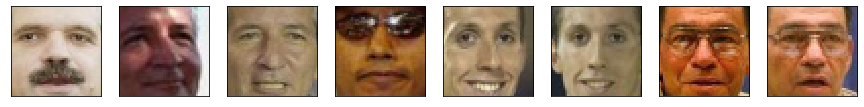

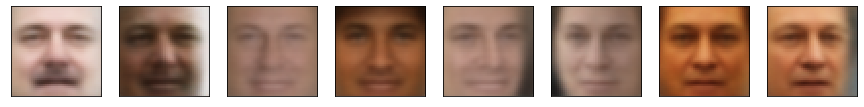

In [0]:
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
inputs, prop = next(iter(val_loader))
VAEmodel.eval()
outputs, mu, logsigma = VAEmodel(inputs.to(DEVICE))
outputs = outputs.data.cpu()
plot_gallery(inputs, n_row=1, n_col=8, need_denorm=False)
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

## Sampling

Попробуем проделать для VAE то же, что и с обычным автоэнкодером - подсунем decoder'у из VAE случайные векторы из нормального распределения и посмотрим, какие лица получатся:

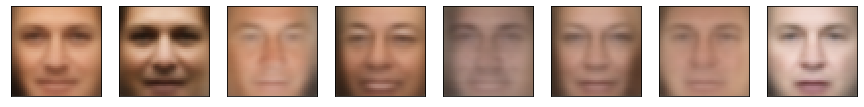

In [0]:
# Сгенерированные новые изображения
VAEmodel.eval()
new_latent = np.array([np.random.normal(0, 1.0, z_dim) for i in range(8)])
outputs = VAEmodel.decode(torch.Tensor(new_latent).to(DEVICE))
outputs = outputs.data.cpu()
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

## Smile adding

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера

In [0]:
# Создадим 2 новых датасета из грустных и счастливых
lim = 1
happy_dataset = MyDataset(data[attrs['Smiling']>lim], attrs_tensor[attrs['Smiling']>lim])
sad_dataset = MyDataset(data[attrs['Smiling']<-lim], attrs_tensor[attrs['Smiling']<-lim])

happy_loader = DataLoader(happy_dataset, batch_size=8, shuffle=False)
sad_loader = DataLoader(sad_dataset, batch_size=8, shuffle=False)

print('счастливых ', len(data[attrs['Smiling']>lim]))
print('грустных ', len(data[attrs['Smiling']<-lim]))

счастливых  2654
грустных  3598


In [0]:
# Посчитаем средний латентный слой счастливых
happy_mean = torch.zeros((z_dim,))
n_pics = 0

VAEmodel.eval()
for inputs, prop in happy_loader:
    mu, _ = VAEmodel.encode(inputs.to(DEVICE))
    n_pics += inputs.shape[0]
    happy_mean += mu.data.mean(axis=0).cpu() * inputs.shape[0]
happy_mean = happy_mean / n_pics

In [0]:
# Посчитаем средний латентный слой грустных
sad_mean = torch.zeros((z_dim,))
n_pics = 0

VAEmodel.eval()
for inputs, prop in sad_loader:
    mu, _ = VAEmodel.encode(inputs.to(DEVICE))
    n_pics += inputs.shape[0]
    sad_mean += mu.data.mean(axis=0).cpu() * inputs.shape[0]
sad_mean = sad_mean / n_pics

In [0]:
# Найдем разницу между счастливыми и грустными 
delta_mean = happy_mean - sad_mean

Грустные


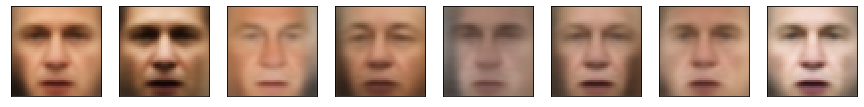

Средние


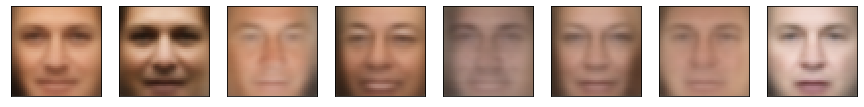

Счастливые


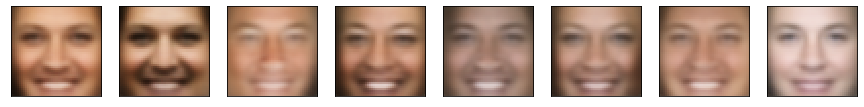

In [0]:
# Сгенерируем новые изображения грустных и счастливых
VAEmodel.eval()
outputs = VAEmodel.decode((torch.Tensor(new_latent)-1.5*delta_mean).to(DEVICE))
outputs = outputs.data.cpu()
print('Грустные')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

outputs = VAEmodel.decode((torch.Tensor(new_latent)-0).to(DEVICE))
outputs = outputs.data.cpu()
print('Средние')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

outputs = VAEmodel.decode((torch.Tensor(new_latent)+1.5*delta_mean).to(DEVICE))
outputs = outputs.data.cpu()
print('Счастливые')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

# Denoising

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

In [0]:
#from copy import deepcopy

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), input.size(1), 1, 1)

class DenoiseAE(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
  
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, z_dim, kernel_size=3),
            nn.BatchNorm2d(z_dim),
            Flatten()   )
        
        self.decoder = nn.Sequential(
            UnFlatten(),             
            nn.ConvTranspose2d(z_dim, 512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 3, kernel_size=3, padding=1)  )

    def decode(self, x):
        return self.decoder(x)
    
    def encode(self, latent_code):
        return self.encoder(latent_code)

    def forward(self, x):
        x = self.encode(x)
        latent_code = x
        reconstruction = self.decode(x)
        return reconstruction, latent_code

In [0]:
denoise_model = DenoiseAE(z_dim=1024).to(DEVICE)
#denoise_model

In [0]:
class MyNoisyDataset(Dataset):
    def __init__(self, files, props):
        super().__init__()
        self.files = files
        self.props = props
        self.len_ = len(self.files)
    
    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        transform = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor(),
          #transforms.Normalize([0.628, 0.471, 0.384], [0.205, 0.182, 0.178])
        ])

        x = self.files[index]
        x = Image.fromarray(x)
        x = transform(x)
        noisy_x = x + 0.25 * torch.randn_like(x)
        y = self.props[index]
        return x, noisy_x, y

In [0]:
train_noisy_dataset = MyNoisyDataset(X_train, y_train)
val_noisy_dataset = MyNoisyDataset(X_val, y_val)
#all_noisy_dataset = MyNosyDataset(data, attrs_tensor)

In [0]:
def train(train_dataset, val_dataset, model, epochs, batch_size, lr=1e-3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    log_template = "Finished epoch {ep:03d} | train_loss {t_loss:0.4f} | val_loss {v_loss:0.4f}"


    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        train_loss = fit_epoch(model, train_loader, criterion, optimizer)
        val_loss = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, val_loss))
        print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # перевод модели в режим train - в данном конкретном случае ни на что не влияет,
    # но необходимо, если в модели есть слои BatchNorm или DropOut
    model.train()
    running_loss = 0.0
    processed_data = 0
    
    for inputs, noisy_inputs, prop in train_loader:
        inputs = inputs.to(DEVICE)
        noisy_inputs = noisy_inputs.to(DEVICE)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs, _ = model(noisy_inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
           
    train_loss = running_loss / processed_data
    return train_loss

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, noisy_inputs, prop in val_loader:
        inputs = inputs.to(DEVICE)
        noisy_inputs = noisy_inputs.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs, _ = model(noisy_inputs)
            loss = criterion(outputs, inputs)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    return val_loss

In [0]:
history=[]
history =  train(train_noisy_dataset, val_noisy_dataset, model=denoise_model, epochs=5, batch_size=64, lr=2e-3)
history += train(train_noisy_dataset, val_noisy_dataset, model=denoise_model, epochs=12, batch_size=64, lr=1e-3)
history += train(train_noisy_dataset, val_noisy_dataset, model=denoise_model, epochs=5, batch_size=64, lr=0.3e-3)
history += train(train_noisy_dataset, val_noisy_dataset, model=denoise_model, epochs=2, batch_size=64, lr=0.1e-3)
history += train(train_noisy_dataset, val_noisy_dataset, model=denoise_model, epochs=2, batch_size=64, lr=0.03e-3)
history += train(train_noisy_dataset, val_noisy_dataset, model=denoise_model, epochs=2, batch_size=64, lr=0.01e-3)

Finished epoch 001 | train_loss 0.0695 | val_loss 0.0118
Finished epoch 002 | train_loss 0.0087 | val_loss 0.0088
Finished epoch 003 | train_loss 0.0069 | val_loss 0.0074
Finished epoch 004 | train_loss 0.0065 | val_loss 0.0065
Finished epoch 005 | train_loss 0.0064 | val_loss 0.0065
Finished epoch 001 | train_loss 0.0068 | val_loss 0.0062
Finished epoch 002 | train_loss 0.0060 | val_loss 0.0058
Finished epoch 003 | train_loss 0.0058 | val_loss 0.0057
Finished epoch 004 | train_loss 0.0057 | val_loss 0.0053
Finished epoch 005 | train_loss 0.0054 | val_loss 0.0056
Finished epoch 006 | train_loss 0.0053 | val_loss 0.0053
Finished epoch 007 | train_loss 0.0052 | val_loss 0.0050
Finished epoch 008 | train_loss 0.0051 | val_loss 0.0053
Finished epoch 009 | train_loss 0.0051 | val_loss 0.0048
Finished epoch 010 | train_loss 0.0050 | val_loss 0.0046
Finished epoch 011 | train_loss 0.0049 | val_loss 0.0048
Finished epoch 012 | train_loss 0.0048 | val_loss 0.0045
Finished epoch 001 | train_loss

Оригинальные


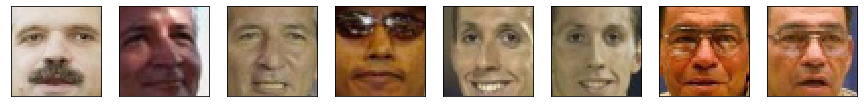

Зашумленные


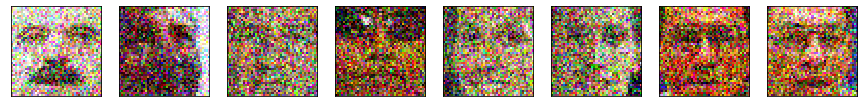

Восстановленные


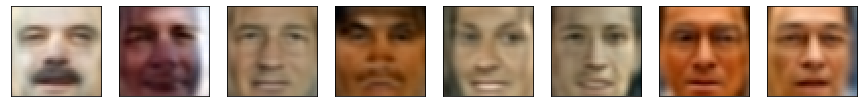

In [0]:
val_noisy_loader = DataLoader(val_noisy_dataset, batch_size=8, shuffle=False)
inputs, noisy_inputs, prop = next(iter(val_noisy_loader))

model.eval()
outputs, latent = denoise_model(noisy_inputs.to(DEVICE))
outputs = outputs.data.cpu()

print('Оригинальные')
plot_gallery(inputs, n_row=1, n_col=8, need_denorm=False)
print('Зашумленные')
plot_gallery(noisy_inputs, n_row=1, n_col=8, need_denorm=False)
print('Восстановленные')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)

# Missing parts restoration

In [0]:
class MyCropyDataset(Dataset):
    def __init__(self, files, props):
        super().__init__()
        self.files = files
        self.props = props
        self.len_ = len(self.files)
    
    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        transform = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor()
          #transforms.Normalize([0.628, 0.471, 0.384], [0.205, 0.182, 0.178])
        ])
        crop_transform = transforms.Compose([
          transforms.RandomErasing(p=1)
        ])
                                        
        x = self.files[index]
        x = Image.fromarray(x)
        x = transform(x)
        croped_x = crop_transform(x)
        y = self.props[index]
        return x, croped_x, y

In [0]:
train_cropy_dataset = MyCropyDataset(X_train, y_train)
val_cropy_dataset = MyCropyDataset(X_val, y_val)
#all_cropy_dataset = MyCropyDataset(data, attrs_tensor)

Воспользуемся той же моделью, что использовалась для избавления от шума:

In [0]:
decrop_model = DenoiseAE(z_dim=1024).to(DEVICE)
#denoise_model

In [0]:
history=[]
history =  train(train_cropy_dataset, val_cropy_dataset, model=decrop_model, epochs=5, batch_size=64, lr=2e-3)
history += train(train_cropy_dataset, val_cropy_dataset, model=decrop_model, epochs=12, batch_size=64, lr=1e-3)
history += train(train_cropy_dataset, val_cropy_dataset, model=decrop_model, epochs=5, batch_size=64, lr=0.3e-3)
history += train(train_cropy_dataset, val_cropy_dataset, model=decrop_model, epochs=2, batch_size=64, lr=0.1e-3)
history += train(train_cropy_dataset, val_cropy_dataset, model=decrop_model, epochs=2, batch_size=64, lr=0.03e-3)
history += train(train_cropy_dataset, val_cropy_dataset, model=decrop_model, epochs=2, batch_size=64, lr=0.01e-3)

Finished epoch 001 | train_loss 0.0770 | val_loss 0.0174
Finished epoch 002 | train_loss 0.0137 | val_loss 0.0134
Finished epoch 003 | train_loss 0.0125 | val_loss 0.0122
Finished epoch 004 | train_loss 0.0119 | val_loss 0.0119
Finished epoch 005 | train_loss 0.0117 | val_loss 0.0116
Finished epoch 001 | train_loss 0.0120 | val_loss 0.0116
Finished epoch 002 | train_loss 0.0114 | val_loss 0.0110
Finished epoch 003 | train_loss 0.0109 | val_loss 0.0108
Finished epoch 004 | train_loss 0.0106 | val_loss 0.0105
Finished epoch 005 | train_loss 0.0104 | val_loss 0.0102
Finished epoch 006 | train_loss 0.0101 | val_loss 0.0099
Finished epoch 007 | train_loss 0.0100 | val_loss 0.0097
Finished epoch 008 | train_loss 0.0098 | val_loss 0.0095
Finished epoch 009 | train_loss 0.0096 | val_loss 0.0094
Finished epoch 010 | train_loss 0.0097 | val_loss 0.0094
Finished epoch 011 | train_loss 0.0094 | val_loss 0.0090
Finished epoch 012 | train_loss 0.0093 | val_loss 0.0092
Finished epoch 001 | train_loss

Кропнутые


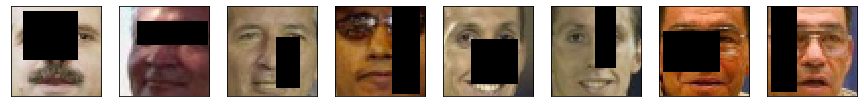

Восстановленные


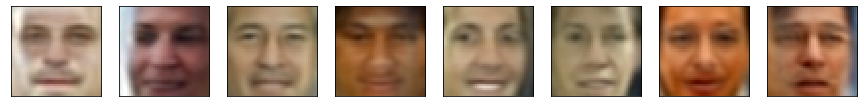

In [0]:
val_cropy_loader = DataLoader(val_cropy_dataset, batch_size=8, shuffle=False)
inputs, croped_inputs, prop = next(iter(val_cropy_loader))

decrop_model.eval()
outputs, latent = decrop_model(croped_inputs.to(DEVICE))
outputs = outputs.data.cpu()

print('Кропнутые')
plot_gallery(croped_inputs, n_row=1, n_col=8, need_denorm=False)
print('Восстановленные')
plot_gallery(outputs, n_row=1, n_col=8, need_denorm=False)